In [1]:
# https://keras.io/examples/vision/handwriting_recognition
# https://keras.io/examples/vision/captcha_ocr
import sys
import tensorflow as tf
sys.path.append('..')
tf.get_logger().setLevel('ERROR')

# Check GPU working

In [2]:
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [3]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0': raise SystemError('GPU device not found')
print('Found GPU at:', device_name)
!nvcc -V

Found GPU at: /device:GPU:0
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Nov_30_19:15:10_Pacific_Standard_Time_2020
Cuda compilation tools, release 11.2, V11.2.67
Build cuda_11.2.r11.2/compiler.29373293_0


# Import the dataset

In [4]:
from dataset_handler import create_dataset, remove_rare_chars
DATA_PATH = '../../Dataset/trdg'
FONT_PATH = '../../Dataset/NomNaTong-Regular.ttf'
HEIGHT = 148
WIDTH = 32

## Load and remove records with rare characters 

In [5]:
img_paths, labels, vocabs = create_dataset(DATA_PATH)
img_paths, labels, vocabs = remove_rare_chars(img_paths, labels, vocabs, threshold=3)
print('Number of images found:', len(img_paths))
print('Number of labels found:', len(labels))
print('Number of unique characters:', len(vocabs))
print('Characters present:', vocabs, sep='')

Number of images found: 2889
Number of labels found: 2889
Number of unique characters: 1697
Characters present:{'㐌': 316, '浪': 300, '朱': 247, '\U000f047c': 214, '\U000f070b': 213, '尼': 210, '吏': 200, '𦋦': 197, '𢚸': 197, '娘': 197, '𠊛': 192, '固': 189, '拱': 172, '之': 167, '情': 161, '埃': 161, '買': 151, '芇': 146, '𠬠': 145, '仙': 139, '欺': 138, '群': 136, '𠳒': 136, '麻': 130, '𠓨': 127, '𧗱': 124, '爫': 122, '別': 118, '塘': 117, '花': 114, '𠫾': 109, '𠄩': 108, '払': 106, '渚': 106, '𡗶': 106, '浽': 104, '傷': 103, '強': 102, '呐': 101, '渃': 99, '𦖑': 99, '饒': 97, '庒': 97, '如': 96, '些': 95, '分': 94, '冲': 94, '畧': 93, '咍': 92, '鐄': 90, '時': 90, '昆': 90, '低': 90, '𢬣': 89, '𡢐': 88, '身': 87, '兜': 87, '𧡊': 86, '於': 86, '細': 84, '生': 81, '月': 79, '公': 78, '戈': 78, '皮': 78, '調': 76, '﨤': 74, '𣈜': 74, '爲': 73, '茹': 73, '沛': 73, '牢': 73, '仍': 73, '油': 73, '命': 72, '排': 70, '典': 66, '包': 66, '娥': 65, '碎': 65, '㗂': 64, '\U000f061a': 63, '雲': 62, '𠁀': 61, '\U000f02c7': 61, '恩': 61, '迻': 59, '耒': 59, '茄': 57, '共': 57, '紅'

## Visualize the data

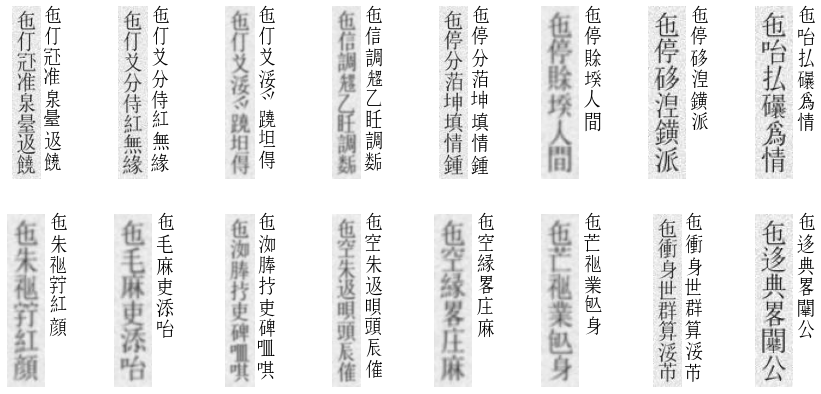

In [6]:
from visualizer import visualize_images_labels
visualize_images_labels(img_paths, labels, font_path=FONT_PATH, text_x=WIDTH + 3)

## Building the character vocabulary

In [7]:
# Mapping characters to integers
char2num = tf.keras.layers.StringLookup(
    vocabulary = list(vocabs), 
    mask_token = None,
    encoding = 'utf-8'
)

# Mapping integers back to original characters
num2char = tf.keras.layers.StringLookup(
    vocabulary = char2num.get_vocabulary(), 
    mask_token = None, 
    invert = True,
    encoding = 'utf-8'
)

# Define the model

In [8]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Bidirectional, GRU
from cnn import custom_cnn, get_imagenet_model, reshape_for_cnn
from ctc import CTCLayer

In [9]:
def build_crnn(name='CRNN', imagenet_model=None, imagenet_output_layer=None):
    label_input = Input(shape=(None,), dtype='int64', name='label')
    label_length = Input(shape=[1], dtype='int64', name='label_length')
    
    # CNN layers
    if imagenet_model: # Use Imagenet model as CNN layers
        image_input = imagenet_model.input
        imagenet_model.layers[0]._name = 'image'
        x = imagenet_model.get_layer(imagenet_output_layer).output
    else: 
        image_input = Input(shape=(HEIGHT, WIDTH, 1), dtype='float32', name='image')
        conv_blocks_config = {
            'block1': {'num_conv': 1, 'filters':  64, 'pool_size': (2, 2)}, 
            'block2': {'num_conv': 1, 'filters': 128, 'pool_size': (2, 2)}, 
            'block3': {'num_conv': 2, 'filters': 256, 'pool_size': (2, 2)}, 
            'block4': {'num_conv': 2, 'filters': 512, 'pool_size': (1, 2)}, 
        }
        x = custom_cnn(conv_blocks_config, image_input)
        
    # Reshape accordingly before passing the output to the RNN
    x = reshape_for_cnn(x, dim_to_keep=-1)

    # RNN layers
    bigru_layers = [512, 512]
    for idx in range(len(bigru_layers)):
        x = Bidirectional(GRU(
            units = bigru_layers[idx], 
            return_sequences = True, 
            dropout = 0.2,
        ), name = f'bigru{idx + 1}')(x)

    # Output layer
    y_pred = Dense(
        units = char2num.vocabulary_size() + 1, # + 1 blank character for CTC loss
        activation = 'softmax', 
        name = 'rnn_output'
    )(x)

    # Compile the model and return
    model = Model(
        inputs = [image_input, label_input, label_length], 
        outputs = CTCLayer()(label_input, y_pred, label_length), 
        name = name
    )
    return model

In [10]:
## Pick a model from https://keras.io/api/applications
# imagenet_model = get_imagenet_model('VGG16', (HEIGHT, WIDTH, 1))
# imagenet_model.summary(line_length=100)

In [11]:
# imagenet_output_layer = 'block3_pool'
# model = build_crnn(imagenet_model, imagenet_output_layer)
model = build_crnn()
model.summary(line_length=100)

Model: "CRNN"
____________________________________________________________________________________________________
 Layer (type)                    Output Shape          Param #     Connected to                     
 image (InputLayer)              [(None, 148, 32, 1)]  0           []                               
                                                                                                    
 block1_conv1 (Conv2D)           (None, 148, 32, 64)   640         ['image[0][0]']                  
                                                                                                    
 block1_bn1 (BatchNormalization)  (None, 148, 32, 64)  256         ['block1_conv1[0][0]']           
                                                                                                    
 block1_activation1 (LeakyReLU)  (None, 148, 32, 64)   0           ['block1_bn1[0][0]']             
                                                                             

# Training

In [12]:
from dataset_handler import process_one_image
MAX_LENGTH = max([len(label) for label in labels])
PADDING_TOKEN = char2num.vocabulary_size()
AUTOTUNE = tf.data.AUTOTUNE
BATCH_SIZE = 16

## Data input pipeline

In [13]:
def process_images_labels(img_path, label, img_size=(HEIGHT, WIDTH)):
    image = process_one_image(img_path, img_size)
    label = char2num(tf.strings.unicode_split(label, input_encoding='UTF-8'))
    label_length = tf.shape(label, tf.int64)[0]
    label = tf.pad(
        label, 
        paddings = [[0, MAX_LENGTH - label_length]], 
        constant_values = PADDING_TOKEN
    )
    return {'image': image, 'label': label, 'label_length': label_length} 

In [14]:
def prepare_tf_dataset(img_paths, labels):
    dataset = tf.data.Dataset.from_tensor_slices((img_paths, labels)).map(
        process_images_labels, num_parallel_calls=AUTOTUNE
    )
    return dataset.batch(BATCH_SIZE).cache().prefetch(AUTOTUNE)

## Callbacks

In [15]:
from tensorflow.keras.callbacks import LearningRateScheduler, ReduceLROnPlateau
from custom_callbacks import EditDistanceCallback, EarlyStoppingWithStuck
early_stopping_callback = EarlyStoppingWithStuck(patience=5)

def scheduler(epoch, lr):
    if epoch == 0 or (epoch % 10) > 0: return lr # Keeps lr for 10 epochs
    return lr * tf.math.exp(-0.2) # Decreases it exponentially after that
schedule_lr_callback = LearningRateScheduler(scheduler, verbose=1)

# Reduce the learning rate once learning stagnates
reduce_lr_callback = ReduceLROnPlateau(
    monitor = 'val_loss', 
    patience = 2, # Reduce if no improvement after 2 epochs
    min_delta = 0.001, # The val_loss should at least improve 0.001
    factor = 0.5, # => new_lr = lr * factor
    verbose = 1
)

## Cross validation with K-Fold

In [16]:
from kfold import kfold_decorator
from tensorflow.keras.optimizers import Adam
LEARNING_RATE = 2e-4
EPOCHS = 100

In [17]:
@kfold_decorator(n_splits=10)
def train(model, img_paths, labels, train_idx=None, valid_idx=None):
    train_tf_dataset = prepare_tf_dataset(img_paths[train_idx], labels[train_idx])
    valid_tf_dataset = prepare_tf_dataset(img_paths[valid_idx], labels[valid_idx])
    
    model.compile(optimizer=Adam(learning_rate=LEARNING_RATE))
    edit_distance_callback = EditDistanceCallback(Model(
        inputs = model.get_layer('image').input, 
        outputs = model.get_layer('rnn_output').output
    ), valid_tf_dataset, MAX_LENGTH)
    
    history = model.fit(
        train_tf_dataset,
        validation_data = valid_tf_dataset,
        epochs = EPOCHS,
        callbacks = [
#             checkpoint_callback,
#             schedule_lr_callback, 
            reduce_lr_callback, 
            edit_distance_callback, 
            early_stopping_callback,
        ],
        verbose = 1
    )
    return (
        valid_tf_dataset, 
        early_stopping_callback.best_epoch, 
        edit_distance_callback.logs,
        history,
    )

In [18]:
%%time
valid_datasets, best_epochs, edist_logs, histories, models = train(model, img_paths, labels)

Start training for Fold 1:
Epoch 1/100
163/163 [==============================] - 14s 49ms/step - loss: 51.2822 - val_loss: 51.7542 - lr: 2.0000e-04
Epoch 2/100
163/163 [==============================] - 5s 32ms/step - loss: 45.6140 - val_loss: 45.8124 - lr: 2.0000e-04
Epoch 3/100
163/163 [==============================] - 5s 32ms/step - loss: 41.1044 - val_loss: 43.6456 - lr: 2.0000e-04
Epoch 4/100
163/163 [==============================] - 5s 32ms/step - loss: 35.3232 - val_loss: 40.9731 - lr: 2.0000e-04
Epoch 5/100
163/163 [==============================] - 5s 32ms/step - loss: 27.5444 - val_loss: 29.3890 - lr: 2.0000e-04
Epoch 6/100
163/163 [==============================] - 5s 32ms/step - loss: 18.2385 - val_loss: 23.1424 - lr: 2.0000e-04
Epoch 7/100
163/163 [==============================] - 5s 32ms/step - loss: 11.3950 - val_loss: 19.5285 - lr: 2.0000e-04
Epoch 8/100
163/163 [==============================] - 5s 32ms/step - loss: 7.0941 - val_loss: 16.6452 - lr: 2.0000e-04
Epoch

Epoch 38/100
163/163 [==============================] - 5s 32ms/step - loss: 0.0388 - val_loss: 6.5546 - lr: 5.0000e-05
Epoch 39/100
163/163 [==============================] - 5s 33ms/step - loss: 0.0356 - val_loss: 6.5167 - lr: 5.0000e-05
Epoch 40/100
163/163 [==============================] - 5s 33ms/step - loss: 0.0328 - val_loss: 6.5048 - lr: 5.0000e-05
Epoch 41/100
163/163 [==============================] - 5s 33ms/step - loss: 0.0303 - val_loss: 6.5269 - lr: 5.0000e-05
Epoch 42/100
163/163 [==============================] - 5s 32ms/step - loss: 0.0282 - val_loss: 6.4806 - lr: 5.0000e-05
Epoch 43/100
163/163 [==============================] - 5s 32ms/step - loss: 0.0262 - val_loss: 6.4571 - lr: 5.0000e-05
Epoch 44/100
163/163 [==============================] - 5s 33ms/step - loss: 0.0245 - val_loss: 6.4475 - lr: 5.0000e-05
Epoch 45/100
163/163 [==============================] - 5s 32ms/step - loss: 0.0230 - val_loss: 6.4667 - lr: 5.0000e-05
Epoch 46/100
163/163 [==================

163/163 [==============================] - 5s 34ms/step - loss: 0.6215 - val_loss: 3.9344 - lr: 2.0000e-04
Epoch 11/100
163/163 [==============================] - 5s 33ms/step - loss: 0.3683 - val_loss: 3.6459 - lr: 2.0000e-04
Epoch 12/100
163/163 [==============================] - 5s 33ms/step - loss: 0.2512 - val_loss: 3.3445 - lr: 2.0000e-04
Epoch 13/100
163/163 [==============================] - 5s 33ms/step - loss: 0.1881 - val_loss: 3.1785 - lr: 2.0000e-04
Epoch 14/100
163/163 [==============================] - 5s 32ms/step - loss: 0.1485 - val_loss: 2.9610 - lr: 2.0000e-04
Epoch 15/100
163/163 [==============================] - 5s 33ms/step - loss: 0.1212 - val_loss: 2.8373 - lr: 2.0000e-04
Epoch 16/100
163/163 [==============================] - 5s 33ms/step - loss: 0.1014 - val_loss: 2.7949 - lr: 2.0000e-04
Epoch 17/100
163/163 [==============================] - 5s 33ms/step - loss: 0.0859 - val_loss: 2.7246 - lr: 2.0000e-04
Epoch 18/100
163/163 [==============================]

Epoch 47/100
163/163 [==============================] - 5s 32ms/step - loss: 0.0073 - val_loss: 2.3315 - lr: 5.0000e-05
Epoch 48/100
163/163 [==============================] - ETA: 0s - loss: 0.0072
Epoch 48: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.
 - Mean edit distance: 1.4342105
163/163 [==============================] - 5s 32ms/step - loss: 0.0072 - val_loss: 2.3312 - lr: 5.0000e-05
Epoch 49/100
162/163 [============================>.] - ETA: 0s - loss: 0.0071 - Mean edit distance: 1.4309211
Restored weights from the end of epoch: 44
163/163 [==============================] - 5s 32ms/step - loss: 0.0071 - val_loss: 2.3582 - lr: 2.5000e-05
Epoch 49: early stopping
Finish training for Fold 3

Start training for Fold 4:
Epoch 1/100
163/163 [==============================] - 11s 44ms/step - loss: 50.9537 - val_loss: 55.0291 - lr: 2.0000e-04
Epoch 2/100
163/163 [==============================] - 5s 32ms/step - loss: 45.1742 - val_loss: 51.1571 - lr: 2.0000e-04


Epoch 34/100
161/163 [============================>.] - ETA: 0s - loss: 0.0225
Epoch 34: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.
 - Mean edit distance: 1.8453947
163/163 [==============================] - 5s 33ms/step - loss: 0.0225 - val_loss: 4.0327 - lr: 5.0000e-05
Epoch 35/100
161/163 [============================>.] - ETA: 0s - loss: 0.0224 - Mean edit distance: 1.8717105
Restored weights from the end of epoch: 30
163/163 [==============================] - 5s 32ms/step - loss: 0.0224 - val_loss: 4.0962 - lr: 2.5000e-05
Epoch 35: early stopping
Finish training for Fold 4

Start training for Fold 5:
Epoch 1/100
163/163 [==============================] - 12s 46ms/step - loss: 50.9869 - val_loss: 57.7617 - lr: 2.0000e-04
Epoch 2/100
163/163 [==============================] - 5s 32ms/step - loss: 45.1421 - val_loss: 47.0378 - lr: 2.0000e-04
Epoch 3/100
163/163 [==============================] - 5s 32ms/step - loss: 40.4384 - val_loss: 41.3917 - lr: 2.0000e-04

Epoch 13/100
163/163 [==============================] - 5s 33ms/step - loss: 0.1943 - val_loss: 2.9971 - lr: 2.0000e-04
Epoch 14/100
163/163 [==============================] - 5s 34ms/step - loss: 0.1519 - val_loss: 2.9217 - lr: 2.0000e-04
Epoch 15/100
163/163 [==============================] - 6s 35ms/step - loss: 0.1231 - val_loss: 2.9082 - lr: 2.0000e-04
Epoch 16/100
163/163 [==============================] - 6s 34ms/step - loss: 0.1022 - val_loss: 2.7910 - lr: 2.0000e-04
Epoch 17/100
163/163 [==============================] - 5s 33ms/step - loss: 0.0864 - val_loss: 2.8136 - lr: 2.0000e-04
Epoch 18/100
163/163 [==============================] - 5s 33ms/step - loss: 0.0746 - val_loss: 2.7871 - lr: 2.0000e-04
Epoch 19/100
163/163 [==============================] - 5s 33ms/step - loss: 0.0644 - val_loss: 2.7261 - lr: 2.0000e-04
Epoch 20/100
163/163 [==============================] - 5s 33ms/step - loss: 0.0565 - val_loss: 2.6901 - lr: 2.0000e-04
Epoch 21/100
163/163 [==================

Epoch 7/100
163/163 [==============================] - 5s 33ms/step - loss: 19.4240 - val_loss: 35.3233 - lr: 2.0000e-04
Epoch 8/100
163/163 [==============================] - 5s 33ms/step - loss: 15.2529 - val_loss: 33.0646 - lr: 2.0000e-04
Epoch 9/100
162/163 [============================>.] - ETA: 0s - loss: 11.5910 - Mean edit distance: 6.332237
Restored weights from the end of epoch: 4
163/163 [==============================] - 5s 33ms/step - loss: 11.5862 - val_loss: 29.0125 - lr: 2.0000e-04
Epoch 9: early stopping
Finish training for Fold 8

Start training for Fold 9:
Epoch 1/100
163/163 [==============================] - 12s 45ms/step - loss: 51.1817 - val_loss: 56.9806 - lr: 2.0000e-04
Epoch 2/100
163/163 [==============================] - 5s 32ms/step - loss: 45.2503 - val_loss: 49.5957 - lr: 2.0000e-04
Epoch 3/100
163/163 [==============================] - 5s 33ms/step - loss: 40.2017 - val_loss: 40.6696 - lr: 2.0000e-04
Epoch 4/100
163/163 [==============================] -

Epoch 35/100
163/163 [==============================] - 5s 33ms/step - loss: 0.0256 - val_loss: 6.6642 - lr: 1.0000e-04
Epoch 36/100
161/163 [============================>.] - ETA: 0s - loss: 0.0243
Epoch 36: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
 - Mean edit distance: 2.180921
163/163 [==============================] - 6s 34ms/step - loss: 0.0243 - val_loss: 6.6396 - lr: 1.0000e-04
Epoch 37/100
163/163 [==============================] - 5s 34ms/step - loss: 0.0237 - val_loss: 6.5055 - lr: 5.0000e-05
Epoch 38/100
163/163 [==============================] - 5s 33ms/step - loss: 0.0228 - val_loss: 6.4711 - lr: 5.0000e-05
Epoch 39/100
163/163 [==============================] - 5s 33ms/step - loss: 0.0219 - val_loss: 6.4824 - lr: 5.0000e-05
Epoch 40/100
161/163 [============================>.] - ETA: 0s - loss: 0.0211
Epoch 40: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.
 - Mean edit distance: 2.1611843
163/163 [===========================

Epoch 21/100
163/163 [==============================] - 5s 33ms/step - loss: 0.0990 - val_loss: 5.1076 - lr: 1.0000e-04
Epoch 22/100
163/163 [==============================] - 5s 33ms/step - loss: 0.0859 - val_loss: 5.0675 - lr: 1.0000e-04
Epoch 23/100
163/163 [==============================] - 5s 33ms/step - loss: 0.0769 - val_loss: 5.0304 - lr: 1.0000e-04
Epoch 24/100
163/163 [==============================] - 5s 33ms/step - loss: 0.0695 - val_loss: 4.9303 - lr: 1.0000e-04
Epoch 25/100
163/163 [==============================] - 5s 33ms/step - loss: 0.0630 - val_loss: 4.8925 - lr: 1.0000e-04
Epoch 26/100
163/163 [==============================] - 5s 33ms/step - loss: 0.0575 - val_loss: 4.8581 - lr: 1.0000e-04
Epoch 27/100
163/163 [==============================] - 5s 33ms/step - loss: 0.0528 - val_loss: 4.8226 - lr: 1.0000e-04
Epoch 28/100
163/163 [==============================] - 5s 33ms/step - loss: 0.0486 - val_loss: 4.7796 - lr: 1.0000e-04
Epoch 29/100
163/163 [==================

## Get the best CRNN model and its results

In [29]:
from kfold import get_best_fold
from visualizer import plot_training_results
(
    best_valid_dataset, 
    best_edist_log, 
    best_history,
    best_model,
    best_fold_idx, 
    best_loss
) = get_best_fold(valid_datasets, best_epochs, edist_logs, histories, models)

Fold 01 - Mean edit distance: 2.1546051502227783
19/19 [==============================] - 0s 15ms/step - loss: 6.4077
Fold 02 - Mean edit distance: 7.690789699554443
19/19 [==============================] - 0s 13ms/step - loss: 39.9676
Fold 03 - Mean edit distance: 1.4342105388641357
19/19 [==============================] - 0s 13ms/step - loss: 2.3210
Fold 04 - Mean edit distance: 1.8486841917037964
19/19 [==============================] - 0s 13ms/step - loss: 3.9902
Fold 05 - Mean edit distance: 7.200657844543457
19/19 [==============================] - 0s 14ms/step - loss: 36.1917
Fold 06 - Mean edit distance: 5.427631378173828
19/19 [==============================] - 0s 14ms/step - loss: 20.8195
Fold 07 - Mean edit distance: 1.4473683834075928
19/19 [==============================] - 0s 13ms/step - loss: 2.4498
Fold 08 - Mean edit distance: 7.7072367668151855
19/19 [==============================] - 0s 14ms/step - loss: 40.5696
Fold 09 - Mean edit distance: 2.1282894611358643
19/19 

Fold 2 has the best loss: 2.3209941387176514


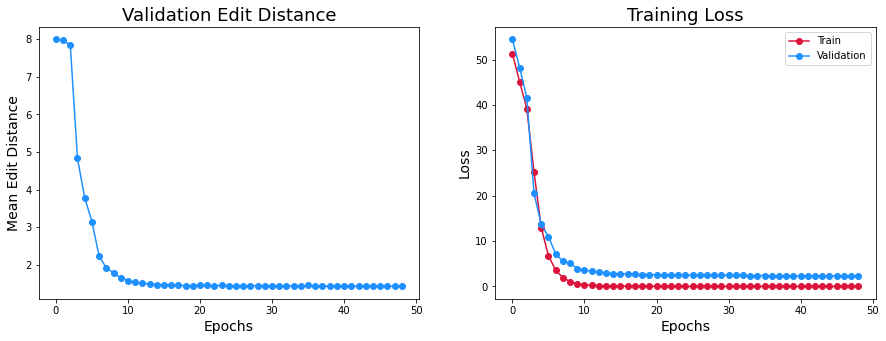

In [31]:
print('Fold', best_fold_idx, 'has the best loss:', best_loss)
plot_training_results(best_history, best_edist_log, 'crnn_trdg_history.png')
best_model.save('crnn_trdg.h5')

# Inference

In [32]:
from tensorflow.keras.models import Model, load_model
from ctc import CTCLayer, decode_batch_predictions
valid_dataset, valid_idxs = best_valid_dataset

## Reload the model

In [34]:
reloaded_model = load_model('crnn_trdg.h5', custom_objects={'CTCLayer': CTCLayer})
reloaded_prediction_model = Model(
    inputs = reloaded_model.get_layer('image').input, 
    outputs = reloaded_model.get_layer('rnn_output').output
)
reloaded_model.summary(line_length=100)

Model: "Model_3"
____________________________________________________________________________________________________
 Layer (type)                    Output Shape          Param #     Connected to                     
 image (InputLayer)              [(None, 148, 32, 1)]  0           []                               
                                                                                                    
 block1_conv1 (Conv2D)           (None, 148, 32, 64)   640         ['image[0][0]']                  
                                                                                                    
 block1_bn1 (BatchNormalization)  (None, 148, 32, 64)  256         ['block1_conv1[0][0]']           
                                                                                                    
 block1_activation1 (LeakyReLU)  (None, 148, 32, 64)   0           ['block1_bn1[0][0]']             
                                                                          

## On test dataset

Batch 1: ['㐌仃𠬠分侍紅無緣', '㐌停𥒥\U000f07ba鐄派', '㐌迻典畧\U000f0607公', '㐌𢚸君子多恾', '㐌𤷱昆𬑉方𡗶\U000f0761\U000f0761', '㝵又䀡𧡊月娥', '䏾花苔坦𨤔銀昂𡗶', '䏾𦝄𣃣格梗橷', '䜹浪碎寔𠊛𬆄', '不情浽陣𩄲湄', '丕𡢐𠦳淡登程買安', '世芇嗔决\U000f070b排朱衝', '世芇娘拱沛𦖑', '世芇拱拯酉衝特芇', '主春停㐌固尼', '丿\U000f0993裴儉𠬠欺𧗱茄']

Batch 2: ['之朋哙吏理芇朱明', '事兜㳥\U000f0284不期', '云仙之掣浽愁', '些低沛摱埃兜𦓡浪', '仃群悲𢪀事𠁀', '仕𦖑世賊㐌散', '仙浪庄掣呐之', '仙浪翁舘唭埃', '仰𬂙量𢌌皮𨕭', '伶伶招隐庵𠀧𫳘排', '体𡎢曳𢪀\U000f02c7𠳒占包', '倍之柳押花奈', '倍嘆移住尼芇', '催時\U000f07ba玉散鐄時催', '傷台身分落類', '傷吒歲鶴㐌高']

Batch 3: ['儉歆群𢪀菫𠽐', '儉浪娘呐差耒', '元戎骨突浽衝', '公浪\U000f0586𩈘𠄩昆', '六公𠳐令細尼营前', '六翁渃𬑉𣻆淶', '共饒呐𠮾𦖑𠳒易漂', '冲朝固𠬠𨉓娘', '几群𠊚𠅍𡗶喂唉𡗶', '判浪朕𢜝渃畨', '別包𧊉𣳮蜂淶', '別𠊛別\U000f061a別𢚸爫牢', '别綠命别分命世傕', '制花㐌易\U000f02c7𠊛别花', '刼尼拯矯填蒲買吹', '刼紅顔固蒙萌']



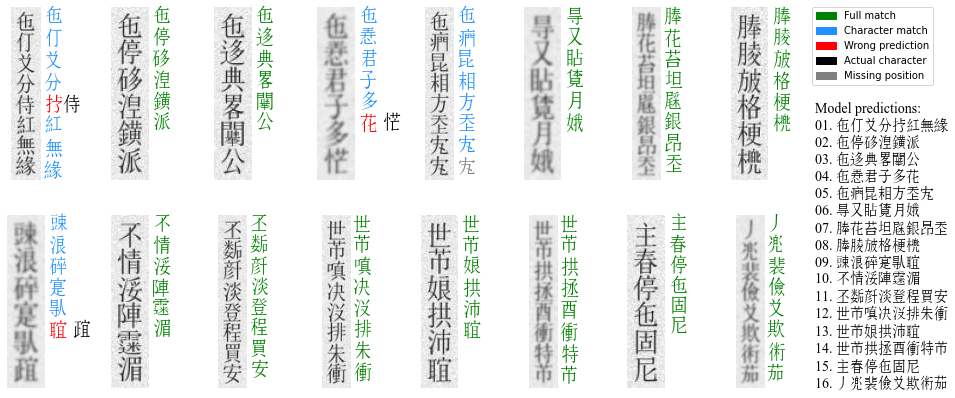

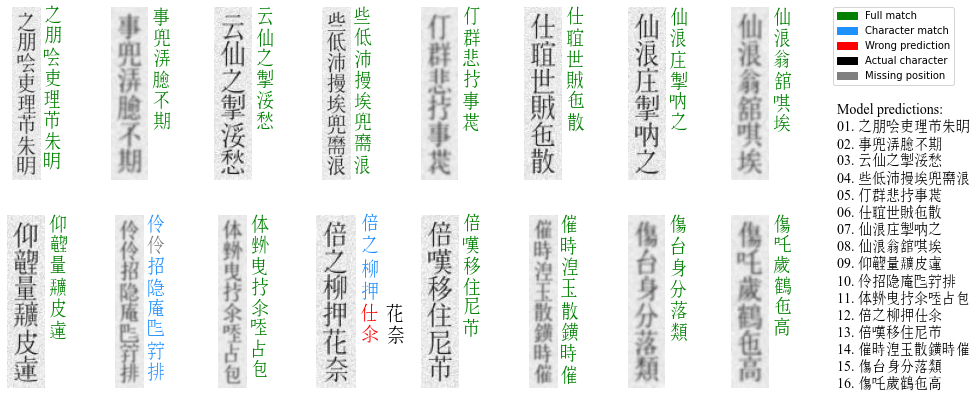

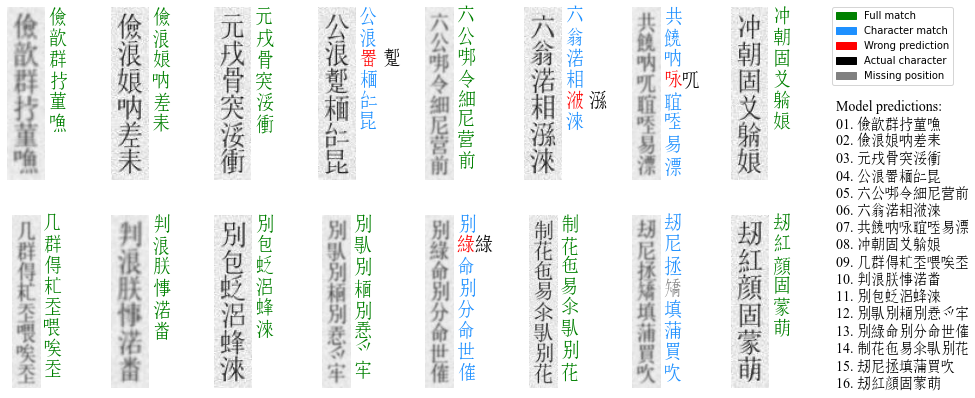

In [36]:
for idx, batch in enumerate(valid_dataset.take(3)):
    idxs_in_batch = valid_idxs[idx * BATCH_SIZE: (idx + 1) * BATCH_SIZE]
    labels_in_batch = []
    
    for label in batch['label']:
        # Gather indices where label != padding_token.
        not_padding = tf.math.not_equal(label, PADDING_TOKEN)
        indices = tf.gather(label, tf.where(not_padding))
        label = tf.strings.reduce_join(num2char(indices)) # Convert to string
        labels_in_batch.append(label.numpy().decode('utf-8'))
        
    preds = reloaded_prediction_model.predict(batch['image'])
    pred_labels = decode_batch_predictions(preds, MAX_LENGTH, 20, num2char)
    visualize_images_labels(
        img_paths = img_paths[idxs_in_batch], 
        labels = labels_in_batch, 
        pred_labels = pred_labels,
        font_path = FONT_PATH, 
        text_x = WIDTH + 3 # Position of actual label to plot
    )
    print(f'Batch {idx + 1}: {labels_in_batch}\n')

## On random image

In [37]:
random_path = '../大越史記全書.jpg'
random_label = '大越史記全書'
random_image = process_images_labels(random_path, random_label)
batch_images = tf.expand_dims(random_image['image'], axis=0)

Predicted text: 大越史記玉書


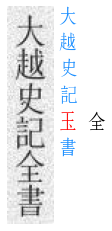

In [38]:
preds = reloaded_prediction_model.predict(batch_images)
pred_labels = decode_batch_predictions(preds, MAX_LENGTH, 20, num2char)
visualize_images_labels(
    img_paths = [random_path], 
    labels = [random_label], 
    pred_labels = pred_labels,
    figsize = (5, 4),
    subplot_size = (1, 1), 
    show_legend = False,
    font_path = FONT_PATH, 
    text_x = WIDTH + 3 # Position of actual label to plot
)
print('Predicted text:', ''.join(pred_labels))